In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

import requests
import json
import urllib
import zipfile
import os
import random

In [9]:
a = set()
a.add(2)
b = set()
b.add(3)
b.add(2)

In [10]:
a.update(b)

In [16]:
random.sample(a,1)

AttributeError: 'list' object has no attribute 'update'

In [7]:
input_data_path = "./ADE20K/code/ADE20K_2016_07_26"

def load_ADE20K_classes(input_data_path):
    from scipy.io import loadmat
    mat_path = os.path.join(input_data_path, "index_ade20k.mat")
    object_names = loadmat(mat_path)['index']['objectnames'][0][0][0]
    ADE20K_CLASSES = {}
    ADE20K_CLASSES_reverse = {}
    for i in range(len(object_names)):
        ADE20K_CLASSES[object_names[i][0]] = i+1
        ADE20K_CLASSES_reverse[i+1] = object_names[i][0]
    return ADE20K_CLASSES, ADE20K_CLASSES_reverse

ADE20K_CLASSES, ADE20K_CLASSES_reverse = load_ADE20K_classes(input_data_path)

In [6]:
COCO_ANN_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
def load_COCO(COCO_ANN_URL, tmp_path):
    import json
    zip_path, hdrs = urllib.request.urlretrieve(COCO_ANN_URL, os.path.join(tmp_path, 
                                                                           "annotations_trainval2017.zip"))
    #logger.info(f"Extracting {zip_path} to temporary folder {tmp_path}...")
    print(f"Extracting {zip_path} to temporary folder {tmp_path}...")
    with zipfile.ZipFile(f"{zip_path}", 'r') as z:
        z.extractall(f"{tmp_path}")
    annot_json_path =  os.path.join(tmp_path, 
                                    "annotations", "instances_val2017.json")
    categories = json.load(open(annot_json_path, 'r'))['categories']
    ids = list(map(lambda d: d['id'], categories))
    labels = list(map(lambda d: d['name'], categories))
    COCO_CLASSES_reverse = dict(zip(ids, labels))
    COCO_CLASSES = dict(zip(labels, ids))
    return COCO_CLASSES, COCO_CLASSES_reverse
COCO_CLASSES, COCO_CLASSES_reverse = load_COCO(COCO_ANN_URL,"./tmp")

Extracting ./tmp/annotations_trainval2017.zip to temporary folder ./tmp...


In [7]:
folder_path ="/home/cindy/Documents/projets/MLPerf/datasets/code/code/ADE20K_2016_07_26/images/training/b/bathroom"
name_img = "ADE_train_00000100"
img_path = os.path.join(folder_path, name_img+"_seg.png")
def get_OM(img_path):
    seg_img = plt.imread(os.path.join(folder_path, name_img+"_seg.png"))
    R = seg_img[:,:,0]*255
    G = seg_img[:,:,1]*255
    B = seg_img[:,:,2]*255
    print(B)
    OM = R/10*256 + G
    return OM.astype("int"), B

[[31. 31. 31. ...  0.  0.  0.]
 [31. 31. 31. ... 51. 51. 51.]
 [31. 31. 31. ... 51. 51. 51.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


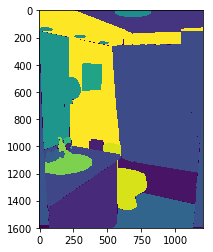

In [9]:
OM,B = get_OM(img_path)
plt.imshow(OM)
n,m = OM.shape

In [24]:
any(is_in_coco(ade_idx) is None for ade_idx in np.unique(OM))

True

In [22]:
all(k is None for k in [None])

True

In [132]:
objects = set()
for i in range(n):
    for j in range(m):
        if OM[i,j] not in objects and OM[i,j]!=0:
            objects.add(OM[i,j])
            if is_in_coco(OM[i,j]):
                print(is_in_coco(OM[i,j]))

62
72


In [13]:
def is_in_coco(ade20K_class_idx):
    if ade20K_class_idx == 0:
        return None
    
    label = ADE20K_CLASSES_reverse[ade20K_class_idx].split(", ")
    for single_label in label:
        if single_label in COCO_CLASSES.keys():
            return COCO_CLASSES[single_label]
    return None

In [114]:
COCO_CLASSES["toilet"]

62

In [249]:
def get_bbox(OM):
    bboxes = {} #bboxes[object_id] = {"label": coco_idx_label, "bbox": [top, bot, left, right]}
    visited = np.zeros_like(OM)
    N, M = OM.shape
    object_id = 0
    for i in range(N):
        for j in range(M):
            if visited[i,j] == 0:
                coco_label = is_in_coco(OM[i,j])
                if not coco_label:
                    visited[i,j] = 1
                else:
                    print(f"coco_label {coco_label}")
                    object_id += 1
                    print(f'New object {(i,j)}')
                    update_object_bbox(OM, 
                                     visited, 
                                     i, j, 
                                     object_id,
                                     coco_label,
                                     bboxes)
    return bboxes


def update_object_bbox(OM, 
                         visited, 
                         i, j, 
                         object_id,
                         coco_label,
                         bboxes):
    
    N, M = OM.shape
    ade_label = OM[i,j]
    
    if object_id not in bboxes:
        bboxes[object_id] = {}
        bboxes[object_id]["label"] = coco_label
        bboxes[object_id]["bbox"] = {}
        bboxes[object_id]["bbox"]["top"] = i 
        bboxes[object_id]["bbox"]["bot"] = i 
        bboxes[object_id]["bbox"]["left"] = j
        bboxes[object_id]["bbox"]["right"] = j
    
    q = [(i,j)]
    cmax= 0
    while q and cmax < 1000000:
        cur_i, cur_j = q.pop(0)
        if visited[cur_i, cur_j] == 0:
            visited[cur_i, cur_j] = 1

            bboxes[object_id]["bbox"]["top"] = min(bboxes[object_id]["bbox"]["top"], cur_i) 
            bboxes[object_id]["bbox"]["bot"] = max(bboxes[object_id]["bbox"]["bot"], cur_i) 
            bboxes[object_id]["bbox"]["left"] = min(bboxes[object_id]["bbox"]["left"], cur_j) 
            bboxes[object_id]["bbox"]["right"] = max(bboxes[object_id]["bbox"]["right"], cur_j) 
            #print(f"*****current i j {(cur_i,cur_j)}")
            if cur_j+1 < M and visited[cur_i, cur_j+1] == 0 and ade_label == OM[cur_i, cur_j+1]:
                if (cur_i, cur_j+1) not in q:
                    q.append((cur_i, cur_j+1))
                    #print(f"adding {(cur_i, cur_j+1)}", q)
            if cur_i+1 < N and visited[cur_i+1, cur_j] == 0 and ade_label == OM[cur_i+1, cur_j]:
                if (cur_i+1, cur_j) not in q:
                    q.append((cur_i+1, cur_j))
                    #print(f"adding {(cur_i+1, cur_j)}", q)
            if cur_j-1 >= 0 and visited[cur_i, cur_j-1] == 0 and ade_label == OM[cur_i, cur_j-1]:
                if (cur_i, cur_j-1) not in q:
                    q.append((cur_i, cur_j-1))
                    #print(f"adding {(cur_i, cur_j-1)}", q)
            if cur_i-1 >= 0 and visited[cur_i-1, cur_j] == 0 and ade_label == OM[cur_i-1, cur_j]:
                if (cur_i-1, cur_j) not in q:
                    q.append((cur_i-1, cur_j))
                    #print(f"adding {(cur_i-1, cur_j)}", q)
        
       # if cmax%10 == 0:
        #    print(visited)
        cmax+=1
    print(visited)
        

In [283]:
def draw_bbox(img_path, bboxes):
    img = plt.imread(img_path)
    plt.imshow(img)
    for obj in bboxes.keys():
        bbox = bboxes[obj]['bbox']
        top_left = (bbox['left'], bbox['top'])
        top_right = (bbox['right'], bbox['top'])
        bot_left = (bbox['left'], bbox['bot'])
        bot_right = (bbox['right'], bbox['bot'])
        print(top_left, top_right)
        plt.plot(*top_left, 'r*')
        plt.plot(*top_right, 'r*')
        plt.plot(*bot_left, 'r*')
        plt.plot(*bot_right, 'r*')
        #plt.plot(469, 977, 'b*')

In [284]:
bboxes

{1: {'label': 62,
  'bbox': {'top': 977, 'bot': 1075, 'left': 469, 'right': 601}},
 2: {'label': 72,
  'bbox': {'top': 1028, 'bot': 1209, 'left': 41, 'right': 388}},
 3: {'label': 62,
  'bbox': {'top': 1101, 'bot': 1468, 'left': 571, 'right': 790}}}

(469, 977) (601, 977)
(41, 1028) (388, 1028)
(571, 1101) (790, 1101)


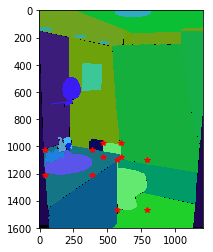

In [285]:
draw_bbox(img_path, bboxes)

In [253]:
OM = get_OM(img_path)
bboxes = get_bbox(OM)

coco_label 62
New object (977, 495)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
coco_label 72
New object (1028, 197)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
coco_label 62
New object (1101, 579)
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [179]:
for key in bboxes.keys():
    if bboxes[key]["label"] != 62:
        print(key, bboxes[key])

111 {'label': 72, 'bbox': {'top': 1028, 'bot': 1036, 'left': 192, 'right': 204}}
115 {'label': 72, 'bbox': {'top': 1030, 'bot': 1039, 'left': 201, 'right': 212}}
123 {'label': 72, 'bbox': {'top': 1032, 'bot': 1041, 'left': 186, 'right': 196}}
124 {'label': 72, 'bbox': {'top': 1033, 'bot': 1042, 'left': 209, 'right': 220}}
129 {'label': 72, 'bbox': {'top': 1035, 'bot': 1045, 'left': 195, 'right': 205}}
135 {'label': 72, 'bbox': {'top': 1037, 'bot': 1047, 'left': 186, 'right': 192}}
136 {'label': 72, 'bbox': {'top': 1037, 'bot': 1046, 'left': 216, 'right': 226}}
140 {'label': 72, 'bbox': {'top': 1038, 'bot': 1048, 'left': 203, 'right': 213}}
143 {'label': 72, 'bbox': {'top': 1040, 'bot': 1050, 'left': 190, 'right': 199}}
147 {'label': 72, 'bbox': {'top': 1042, 'bot': 1052, 'left': 210, 'right': 220}}
148 {'label': 72, 'bbox': {'top': 1042, 'bot': 1051, 'left': 222, 'right': 232}}
155 {'label': 72, 'bbox': {'top': 1044, 'bot': 1053, 'left': 198, 'right': 207}}
158 {'label': 72, 'bbox': {'

In [183]:
test = np.zeros((4,4))
def change(m):
    m[3,3] = 1
change(test)
test

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

# Count intersection images

In [175]:
ade_path = "./ADE20K/code/ADE20K_2016_07_26/images/"
train_path = f"{ade_path}/training"
val_path = f"{ade_path}/val_path"

intersecting_img = set()

for set_path in [train_path, val_path]:
    for letter in os.listdir(set_path):
        letter_path = os.path.join(set_path, letter)
        ADE_letter_classes = os.listdir(letter_path)
        for cur_class in ADE_letter_classes:
            class_path = os.path.join(letter_path, cur_class)
            for f in os.listdir(class_path):
                if f.endswith(".txt"):
                    txt_path = os.path.join(class_path, f)
                    with open(txt_path, 'r') as f:
                        content = f.read().split("\n")
                    for line in content[:-1]:
                        line = line.split(" # ")
                        if line[1] == '0':
                            ade_idx = ADE20K_CLASSES[line[3]]
                            coco_label =  is_in_coco(ade_idx)
                            if coco_label:
                                print(COCO_CLASSES_reverse[coco_label], txt_path.split("/")[-1])
                                intersecting_img.add(txt_path)

chair ADE_train_00020031_atr.txt
couch ADE_train_00020031_atr.txt
vase ADE_train_00020031_atr.txt
book ADE_train_00020017_atr.txt
book ADE_train_00020017_atr.txt
vase ADE_train_00020017_atr.txt
couch ADE_train_00020003_atr.txt
vase ADE_train_00020003_atr.txt
tv ADE_train_00020012_atr.txt
clock ADE_train_00020027_atr.txt
book ADE_train_00020027_atr.txt
person ADE_train_00020027_atr.txt
bed ADE_train_00020005_atr.txt
couch ADE_train_00020041_atr.txt
remote ADE_train_00020041_atr.txt
chair ADE_train_00020040_atr.txt
bed ADE_train_00020040_atr.txt
chair ADE_train_00020002_atr.txt
chair ADE_train_00020037_atr.txt
chair ADE_train_00020037_atr.txt
person ADE_train_00020037_atr.txt
book ADE_train_00020037_atr.txt
book ADE_train_00020032_atr.txt
bed ADE_train_00020016_atr.txt
chair ADE_train_00020010_atr.txt
chair ADE_train_00020010_atr.txt
chair ADE_train_00020010_atr.txt
person ADE_train_00020023_atr.txt
book ADE_train_00020026_atr.txt
bed ADE_train_00020039_atr.txt
vase ADE_train_00020039_at

chair ADE_train_00019502_atr.txt
person ADE_train_00019502_atr.txt
couch ADE_train_00019503_atr.txt
chair ADE_train_00019503_atr.txt
chair ADE_train_00019503_atr.txt
chair ADE_train_00019501_atr.txt
chair ADE_train_00019504_atr.txt
chair ADE_train_00019504_atr.txt
chair ADE_train_00019504_atr.txt
chair ADE_train_00019504_atr.txt
chair ADE_train_00019505_atr.txt
chair ADE_train_00019505_atr.txt
chair ADE_train_00019506_atr.txt
chair ADE_train_00019506_atr.txt
chair ADE_train_00019506_atr.txt
person ADE_train_00019475_atr.txt
person ADE_train_00019470_atr.txt
keyboard ADE_train_00019470_atr.txt
keyboard ADE_train_00019470_atr.txt
keyboard ADE_train_00019470_atr.txt
person ADE_train_00019473_atr.txt
person ADE_train_00019473_atr.txt
person ADE_train_00019473_atr.txt
person ADE_train_00019473_atr.txt
person ADE_train_00019473_atr.txt
car ADE_train_00019451_atr.txt
person ADE_train_00019467_atr.txt
person ADE_train_00019440_atr.txt
person ADE_train_00019440_atr.txt
person ADE_train_00019440

chair ADE_train_00015836_atr.txt
chair ADE_train_00015836_atr.txt
chair ADE_train_00015836_atr.txt
bottle ADE_train_00015836_atr.txt
chair ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
car ADE_train_00015819_atr.txt
car ADE_train_00015819_atr.txt
car ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
umbrella ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
person ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
chair ADE_train_00015819_atr.txt
tr

bench ADE_train_00006410_atr.txt
bench ADE_train_00006410_atr.txt
bench ADE_train_00006410_atr.txt
bench ADE_train_00006410_atr.txt
chair ADE_train_00006410_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006418_atr.txt
chair ADE_train_00006404_atr.txt
chair ADE_train_00006404_atr.txt
chair ADE_train_00006404_atr.txt
cup ADE_train_00006404_atr.txt
chair ADE_train_00006420_atr.txt
chair ADE_train_00006420_atr.txt
chair ADE_train_00006420_atr.txt
chair ADE_train_00006420_atr.txt
person ADE_train_00006420_atr.txt
chair ADE_train_00006420_atr.txt
chair ADE_train_00006420_atr.txt
chair ADE_train_00006408_atr.txt
clock ADE_train_00006408_atr.txt
chair ADE_train_00006415_atr.txt
chair ADE_train_00006415_atr.txt
clock ADE_t

bench ADE_train_00006147_atr.txt
bench ADE_train_00006146_atr.txt
bench ADE_train_00006146_atr.txt
bench ADE_train_00006146_atr.txt
person ADE_train_00006150_atr.txt
person ADE_train_00006150_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
clock ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
person ADE_train_00004950_atr.txt
bench ADE_train_00004949_atr.txt
person ADE_train_00004949_atr.txt
person ADE_train_00004949_atr.txt
bench ADE_train_00004949_atr.txt
bench ADE_train_00004949_atr.txt
person ADE_train_00004949_atr.txt
person ADE_train_00004949_atr.txt
person ADE_train_00004949_atr.txt
person ADE_train_00004949_atr.txt
bench ADE_train_00004949_atr.txt
bench ADE_train_00004949_atr.txt
bench ADE_train_00004949_atr.txt
bench ADE_train_00004949_

book ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
vase ADE_train_00006110_atr.txt
chair ADE_train_00006110_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_train_00006113_atr.txt
chair ADE_tr

person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
chair ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
cup ADE_train_00011770_atr.txt
cup ADE_train_00011770_atr.txt
person ADE_train_00011770_atr.txt
clock ADE_train_00011768_atr.txt
person ADE_train_00011771_atr.txt
person ADE_train_00011771_atr.txt
person ADE_train_00011771_atr

microwave ADE_train_00000617_atr.txt
oven ADE_train_00000617_atr.txt
vase ADE_train_00000617_atr.txt
refrigerator ADE_train_00000617_atr.txt
chair ADE_train_00000617_atr.txt
chair ADE_train_00000617_atr.txt
chair ADE_train_00000617_atr.txt
sink ADE_train_00000617_atr.txt
refrigerator ADE_train_00010318_atr.txt
oven ADE_train_00010318_atr.txt
microwave ADE_train_00010318_atr.txt
chair ADE_train_00010318_atr.txt
couch ADE_train_00010383_atr.txt
refrigerator ADE_train_00010383_atr.txt
clock ADE_train_00010383_atr.txt
couch ADE_train_00010383_atr.txt
couch ADE_train_00010383_atr.txt
oven ADE_train_00010383_atr.txt
microwave ADE_train_00010383_atr.txt
microwave ADE_train_00010316_atr.txt
sink ADE_train_00010316_atr.txt
chair ADE_train_00010316_atr.txt
microwave ADE_train_00010192_atr.txt
clock ADE_train_00010192_atr.txt
sink ADE_train_00010192_atr.txt
bowl ADE_train_00010192_atr.txt
bottle ADE_train_00010192_atr.txt
chair ADE_train_00010428_atr.txt
oven ADE_train_00010428_atr.txt
couch ADE_

refrigerator ADE_train_00010687_atr.txt
microwave ADE_train_00010687_atr.txt
sink ADE_train_00010687_atr.txt
refrigerator ADE_train_00010510_atr.txt
bowl ADE_train_00010510_atr.txt
sink ADE_train_00010510_atr.txt
bottle ADE_train_00010510_atr.txt
knife ADE_train_00010510_atr.txt
microwave ADE_train_00010376_atr.txt
sink ADE_train_00010376_atr.txt
sink ADE_train_00010341_atr.txt
bottle ADE_train_00010660_atr.txt
vase ADE_train_00010660_atr.txt
microwave ADE_train_00010660_atr.txt
toaster ADE_train_00010660_atr.txt
sink ADE_train_00010660_atr.txt
bowl ADE_train_00010660_atr.txt
vase ADE_train_00010660_atr.txt
bottle ADE_train_00010660_atr.txt
vase ADE_train_00010660_atr.txt
bowl ADE_train_00010660_atr.txt
book ADE_train_00010660_atr.txt
bowl ADE_train_00010660_atr.txt
vase ADE_train_00010660_atr.txt
knife ADE_train_00010660_atr.txt
bowl ADE_train_00010660_atr.txt
microwave ADE_train_00010465_atr.txt
chair ADE_train_00010465_atr.txt
cup ADE_train_00010465_atr.txt
sink ADE_train_00010465_a

person ADE_train_00008774_atr.txt
person ADE_train_00008774_atr.txt
person ADE_train_00008774_atr.txt
person ADE_train_00008774_atr.txt
person ADE_train_00008774_atr.txt
person ADE_train_00008774_atr.txt
person ADE_train_00008774_atr.txt
couch ADE_train_00008796_atr.txt
car ADE_train_00008767_atr.txt
car ADE_train_00008767_atr.txt
person ADE_train_00008767_atr.txt
person ADE_train_00008772_atr.txt
person ADE_train_00008764_atr.txt
person ADE_train_00008773_atr.txt
car ADE_train_00008771_atr.txt
car ADE_train_00008771_atr.txt
person ADE_train_00008771_atr.txt
person ADE_train_00008542_atr.txt
person ADE_train_00008542_atr.txt
vase ADE_train_00008542_atr.txt
person ADE_train_00008542_atr.txt
person ADE_train_00008542_atr.txt
person ADE_train_00008542_atr.txt
person ADE_train_00008542_atr.txt
person ADE_train_00008539_atr.txt
person ADE_train_00008539_atr.txt
car ADE_train_00008518_atr.txt
car ADE_train_00008529_atr.txt
car ADE_train_00008529_atr.txt
car ADE_train_00008529_atr.txt
car ADE

book ADE_train_00001836_atr.txt
book ADE_train_00001836_atr.txt
book ADE_train_00001836_atr.txt
book ADE_train_00001836_atr.txt
person ADE_train_00001822_atr.txt
couch ADE_train_00001822_atr.txt
book ADE_train_00001823_atr.txt
book ADE_train_00001823_atr.txt
book ADE_train_00001823_atr.txt
chair ADE_train_00001823_atr.txt
person ADE_train_00001819_atr.txt
person ADE_train_00001819_atr.txt
bed ADE_train_00001816_atr.txt
refrigerator ADE_train_00001828_atr.txt
microwave ADE_train_00001828_atr.txt
bottle ADE_train_00001828_atr.txt
bottle ADE_train_00001828_atr.txt
vase ADE_train_00001828_atr.txt
chair ADE_train_00001828_atr.txt
chair ADE_train_00001828_atr.txt
bottle ADE_train_00001828_atr.txt
chair ADE_train_00001835_atr.txt
chair ADE_train_00001835_atr.txt
vase ADE_train_00001835_atr.txt
couch ADE_train_00001829_atr.txt
couch ADE_train_00001829_atr.txt
vase ADE_train_00001829_atr.txt
tv ADE_train_00001829_atr.txt
chair ADE_train_00001829_atr.txt
book ADE_train_00001808_atr.txt
chair ADE

person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
laptop ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
bottle ADE_train_00002007_atr.txt
person ADE_train_00002007_atr.txt
chair ADE_train_00001988_atr.txt
chair ADE_train_00002002_atr.txt
chair ADE_train_

person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_train_00001498_atr.txt
person ADE_tra

chair ADE_train_00006964_atr.txt
chair ADE_train_00006964_atr.txt
chair ADE_train_00006964_atr.txt
chair ADE_train_00006964_atr.txt
chair ADE_train_00006964_atr.txt
chair ADE_train_00006964_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
vase ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
vase ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
book ADE_train_00007192_atr.txt
chair ADE_train_00007192_atr.txt
vase ADE_train_00007192_atr.txt
chair ADE_train_00007127_atr.txt
chair ADE_train_0000712

chair ADE_train_00006894_atr.txt
chair ADE_train_00006894_atr.txt
chair ADE_train_00006894_atr.txt
chair ADE_train_00006894_atr.txt
chair ADE_train_00006894_atr.txt
chair ADE_train_00006894_atr.txt
vase ADE_train_00006894_atr.txt
chair ADE_train_00007136_atr.txt
chair ADE_train_00007136_atr.txt
chair ADE_train_00007136_atr.txt
chair ADE_train_00007136_atr.txt
chair ADE_train_00007136_atr.txt
vase ADE_train_00007136_atr.txt
chair ADE_train_00007136_atr.txt
chair ADE_train_00006879_atr.txt
chair ADE_train_00006879_atr.txt
chair ADE_train_00006879_atr.txt
vase ADE_train_00006879_atr.txt
vase ADE_train_00006879_atr.txt
vase ADE_train_00006879_atr.txt
chair ADE_train_00006879_atr.txt
chair ADE_train_00007147_atr.txt
chair ADE_train_00007147_atr.txt
chair ADE_train_00007147_atr.txt
chair ADE_train_00007147_atr.txt
chair ADE_train_00007147_atr.txt
clock ADE_train_00007147_atr.txt
chair ADE_train_00007147_atr.txt
vase ADE_train_00007147_atr.txt
vase ADE_train_00007147_atr.txt
vase ADE_train_00

sink ADE_train_00002598_atr.txt
toilet ADE_train_00002598_atr.txt
toilet ADE_train_00000116_atr.txt
sink ADE_train_00000116_atr.txt
vase ADE_train_00002735_atr.txt
vase ADE_train_00002735_atr.txt
sink ADE_train_00002735_atr.txt
sink ADE_train_00002735_atr.txt
sink ADE_train_00002801_atr.txt
sink ADE_train_00002801_atr.txt
chair ADE_train_00002801_atr.txt
sink ADE_train_00002897_atr.txt
sink ADE_train_00002897_atr.txt
sink ADE_train_00002897_atr.txt
sink ADE_train_00002579_atr.txt
sink ADE_train_00002890_atr.txt
sink ADE_train_00002878_atr.txt
vase ADE_train_00002878_atr.txt
sink ADE_train_00000146_atr.txt
toilet ADE_train_00000146_atr.txt
sink ADE_train_00002999_atr.txt
sink ADE_train_00002999_atr.txt
bottle ADE_train_00002999_atr.txt
vase ADE_train_00002999_atr.txt
sink ADE_train_00002619_atr.txt
toilet ADE_train_00002847_atr.txt
toilet ADE_train_00002874_atr.txt
bottle ADE_train_00002874_atr.txt
toilet ADE_train_00002578_atr.txt
toilet ADE_train_00002979_atr.txt
vase ADE_train_000029

bottle ADE_train_00002832_atr.txt
bottle ADE_train_00002832_atr.txt
bottle ADE_train_00002832_atr.txt
sink ADE_train_00002587_atr.txt
toilet ADE_train_00002587_atr.txt
sink ADE_train_00002590_atr.txt
toilet ADE_train_00002590_atr.txt
vase ADE_train_00000174_atr.txt
vase ADE_train_00000174_atr.txt
bottle ADE_train_00000174_atr.txt
sink ADE_train_00000174_atr.txt
toothbrush ADE_train_00000189_atr.txt
sink ADE_train_00000189_atr.txt
toothbrush ADE_train_00000189_atr.txt
sink ADE_train_00002671_atr.txt
sink ADE_train_00000075_atr.txt
bottle ADE_train_00000075_atr.txt
bottle ADE_train_00000075_atr.txt
bench ADE_train_00000075_atr.txt
bottle ADE_train_00000075_atr.txt
sink ADE_train_00000190_atr.txt
sink ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_atr.txt
bottle ADE_train_00002660_a

person ADE_train_00004903_atr.txt
person ADE_train_00004903_atr.txt
person ADE_train_00004903_atr.txt
person ADE_train_00004903_atr.txt
person ADE_train_00004903_atr.txt
person ADE_train_00004904_atr.txt
person ADE_train_00004912_atr.txt
person ADE_train_00004912_atr.txt
person ADE_train_00004912_atr.txt
chair ADE_train_00004911_atr.txt
tv ADE_train_00004911_atr.txt
person ADE_train_00004911_atr.txt
person ADE_train_00004292_atr.txt
scissors ADE_train_00004292_atr.txt
person ADE_train_00004423_atr.txt
person ADE_train_00004423_atr.txt
person ADE_train_00000554_atr.txt
bench ADE_train_00000554_atr.txt
person ADE_train_00000554_atr.txt
person ADE_train_00004426_atr.txt
person ADE_train_00004426_atr.txt
car ADE_train_00002469_atr.txt
car ADE_train_00002469_atr.txt
person ADE_train_00002472_atr.txt
person ADE_train_00002472_atr.txt
person ADE_train_00002472_atr.txt
car ADE_train_00002465_atr.txt
car ADE_train_00002465_atr.txt
car ADE_train_00002465_atr.txt
person ADE_train_00002465_atr.txt

book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004390_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE_train_00004384_atr.txt
book ADE

bed ADE_train_00003994_atr.txt
chair ADE_train_00004176_atr.txt
bed ADE_train_00004176_atr.txt
laptop ADE_train_00004176_atr.txt
bed ADE_train_00003272_atr.txt
tv ADE_train_00003272_atr.txt
bottle ADE_train_00003272_atr.txt
chair ADE_train_00003272_atr.txt
bed ADE_train_00004100_atr.txt
bed ADE_train_00003542_atr.txt
book ADE_train_00003542_atr.txt
book ADE_train_00003542_atr.txt
book ADE_train_00003542_atr.txt
vase ADE_train_00003542_atr.txt
bed ADE_train_00000451_atr.txt
vase ADE_train_00000451_atr.txt
bed ADE_train_00000483_atr.txt
bed ADE_train_00000483_atr.txt
bed ADE_train_00004069_atr.txt
book ADE_train_00004069_atr.txt
bed ADE_train_00003749_atr.txt
bed ADE_train_00003749_atr.txt
bed ADE_train_00000217_atr.txt
bowl ADE_train_00000217_atr.txt
chair ADE_train_00003225_atr.txt
tv ADE_train_00003225_atr.txt
bed ADE_train_00003225_atr.txt
book ADE_train_00003225_atr.txt
book ADE_train_00003225_atr.txt
bed ADE_train_00000416_atr.txt
vase ADE_train_00000360_atr.txt
book ADE_train_0000

bed ADE_train_00003864_atr.txt
vase ADE_train_00003864_atr.txt
bowl ADE_train_00003864_atr.txt
bed ADE_train_00000235_atr.txt
tv ADE_train_00000495_atr.txt
tv ADE_train_00000356_atr.txt
bed ADE_train_00000356_atr.txt
bed ADE_train_00003257_atr.txt
chair ADE_train_00003380_atr.txt
bed ADE_train_00003380_atr.txt
tv ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
chair ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
book ADE_train_00003380_atr.txt
bed ADE_train_00003341_atr.txt
bed ADE_train_00003341_atr.txt
bed ADE_train_00003940_atr.txt
bed ADE_train_00004095_atr.txt
cup ADE_train_00004095_atr.txt
bed ADE_train_00000547_atr.txt
bed ADE_train_00004147_atr.txt
vase ADE_train_00004147_atr.txt
bed ADE_train_00003818_atr.txt
bottle ADE_train_00003818_atr.txt
bottle ADE_train_00003818_atr.txt
book ADE_train_00003812_atr.txt
vase ADE_train_000038

bed ADE_train_00003575_atr.txt
bed ADE_train_00004212_atr.txt
couch ADE_train_00004212_atr.txt
bed ADE_train_00004212_atr.txt
bed ADE_train_00004212_atr.txt
clock ADE_train_00003420_atr.txt
bottle ADE_train_00003420_atr.txt
bed ADE_train_00003420_atr.txt
bottle ADE_train_00003420_atr.txt
couch ADE_train_00000236_atr.txt
bed ADE_train_00000236_atr.txt
chair ADE_train_00000236_atr.txt
toilet ADE_train_00000259_atr.txt
bed ADE_train_00003261_atr.txt
bed ADE_train_00000521_atr.txt
bed ADE_train_00000521_atr.txt
bed ADE_train_00004182_atr.txt
bowl ADE_train_00004182_atr.txt
vase ADE_train_00004182_atr.txt
bed ADE_train_00004011_atr.txt
bed ADE_train_00004074_atr.txt
bed ADE_train_00003230_atr.txt
bed ADE_train_00003882_atr.txt
couch ADE_train_00003882_atr.txt
couch ADE_train_00003278_atr.txt
bed ADE_train_00003278_atr.txt
bed ADE_train_00003888_atr.txt
bed ADE_train_00004103_atr.txt
bed ADE_train_00003795_atr.txt
bed ADE_train_00000364_atr.txt
bed ADE_train_00000364_atr.txt
chair ADE_train_

person ADE_train_00017536_atr.txt
traffic light ADE_train_00017536_atr.txt
car ADE_train_00018535_atr.txt
truck ADE_train_00018535_atr.txt
fire hydrant ADE_train_00018535_atr.txt
car ADE_train_00018535_atr.txt
car ADE_train_00018535_atr.txt
umbrella ADE_train_00018535_atr.txt
car ADE_train_00018109_atr.txt
car ADE_train_00018109_atr.txt
car ADE_train_00018109_atr.txt
car ADE_train_00018109_atr.txt
car ADE_train_00018109_atr.txt
person ADE_train_00017841_atr.txt
car ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
bench ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
person ADE_train_00017841_atr.txt
car ADE_train_00017704_atr.txt
car ADE_train_00017704_atr.txt
car ADE_train_00017704_atr.txt
car ADE_train_00017704_atr.txt
car ADE_train_00017704_atr.txt
car ADE_train_00017704_atr.txt
car ADE_train_00017704_atr.txt
traffic light A

person ADE_train_00018161_atr.txt
backpack ADE_train_00018161_atr.txt
suitcase ADE_train_00018161_atr.txt
person ADE_train_00018161_atr.txt
person ADE_train_00018161_atr.txt
umbrella ADE_train_00018161_atr.txt
person ADE_train_00018161_atr.txt
bicycle ADE_train_00018161_atr.txt
person ADE_train_00018161_atr.txt
car ADE_train_00017749_atr.txt
bicycle ADE_train_00017749_atr.txt
car ADE_train_00017749_atr.txt
car ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
person ADE_train_00017749_atr.txt
car ADE_train_00017247_atr.txt
car ADE_train_00017247_atr.txt
car ADE_train_00017247_atr.txt
car ADE_train_00017247_atr.txt
car ADE_train_00017247_atr.txt
car ADE_train_00017247_atr.txt
car ADE_train_00017247_atr.txt
ca

car ADE_train_00016976_atr.txt
car ADE_train_00016976_atr.txt
bus ADE_train_00016976_atr.txt
car ADE_train_00016976_atr.txt
car ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
dog ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
truck ADE_train_00016976_atr.txt
car ADE_train_00016976_atr.txt
parking meter ADE_train_00016976_atr.txt
car ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
traffic light ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
car ADE_train_00016976_atr.txt
person ADE_train_00016976_atr.txt
umbrella ADE_train_00016976_atr.txt
car ADE_train_00018128_atr.txt
person ADE_train_00018128_atr.txt
car ADE_train_00018128_atr.txt
car ADE_train_00018128_atr.txt
person ADE_train_00018128_atr.txt
car ADE_train_00018602_atr.txt
truc

car ADE_train_00017015_atr.txt
car ADE_train_00017015_atr.txt
car ADE_train_00017015_atr.txt
car ADE_train_00017015_atr.txt
truck ADE_train_00017015_atr.txt
car ADE_train_00017015_atr.txt
person ADE_train_00017015_atr.txt
person ADE_train_00017015_atr.txt
truck ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
person ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
car ADE_train_00017665_atr.txt
person ADE_train_00017665_atr.txt
person ADE_train_00017665_atr.txt
person ADE_train_00017665_atr.txt
person ADE_train_00017665_atr.txt
person ADE_train_00017665_atr.txt
car ADE_train_00017301_atr.txt
car ADE_train_00017301_atr.txt
bicycle ADE_train_00017301_atr.txt
car ADE_train_00017301_atr.txt
parking meter ADE_train_00017301_atr.txt
person ADE_train_00018770_atr.txt
person ADE_train_00018770_atr.txt
person ADE_train_00018

car ADE_train_00018389_atr.txt
car ADE_train_00018389_atr.txt
car ADE_train_00018389_atr.txt
car ADE_train_00018389_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00018800_atr.txt
car ADE_train_00017405_atr.txt
bicycle ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
bus ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
bicycle ADE_train_00017405_atr.txt
bicycle ADE_train_00017405_atr.txt
bicycle ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
bicycle ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
person ADE_train_00017405_atr.txt
car ADE_train_00017872_atr.txt
car ADE_train_00017872_atr.txt
car ADE_train_00017872_

truck ADE_train_00018880_atr.txt
car ADE_train_00018880_atr.txt
car ADE_train_00018880_atr.txt
car ADE_train_00018880_atr.txt
car ADE_train_00018880_atr.txt
car ADE_train_00018880_atr.txt
car ADE_train_00018880_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00018830_atr.txt
car ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
bench ADE_train_00017149_atr.txt
bus ADE_train_00017149_atr.txt
person ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
bench ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
car ADE_train_00017149_atr.txt
bus ADE_train_00017149_atr.txt
person ADE_train_00017149_atr.txt
car ADE_train_00018550_atr.txt
car ADE_train_00018550_atr.

bench ADE_train_00018480_atr.txt
person ADE_train_00018480_atr.txt
person ADE_train_00018480_atr.txt
person ADE_train_00018480_atr.txt
car ADE_train_00017518_atr.txt
car ADE_train_00017518_atr.txt
car ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
person ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
car ADE_train_00018132_atr.txt
person ADE_train_00018132_atr.txt
person ADE_train_00018132_atr.txt
traffic light ADE_train_00018132_atr.txt
traffic light ADE_train_00018132_atr.txt
person ADE_train_00018132_atr.txt
person ADE_train_00018132_atr.txt
person ADE_train_00018132_atr.txt
bicycle ADE_train_00018132_atr.txt
car ADE_train_00017036_atr.txt
person ADE_train_00017036_atr.txt
traffic light ADE_train_00017036_atr.txt
car ADE_train_00018520_atr.txt
person ADE_train_00018520_atr.txt
person ADE_train_00018520_atr.txt
car ADE_train_00018520_atr.tx

car ADE_train_00017261_atr.txt
bicycle ADE_train_00017261_atr.txt
car ADE_train_00018768_atr.txt
person ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
car ADE_train_00018768_atr.txt
person ADE_train_00018768_atr.txt
person ADE_train_00018768_atr.txt
person ADE_train_00018768_atr.txt
car ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
car ADE_train_00018262_atr.txt
umbrella ADE_train_00018262_atr.txt
person ADE_train_00018262_atr.txt
car ADE_train_00018231_atr.txt
car ADE_train_00018231_atr.txt
car ADE_train_00018231_atr.txt
car ADE_train_00018231_atr.txt
chair ADE_train_00018231_atr.txt
bicycle ADE_train_00018042

car ADE_train_00018789_atr.txt
person ADE_train_00018789_atr.txt
person ADE_train_00018789_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00018648_atr.txt
car ADE_train_00017006_atr.txt
bus ADE_train_00017006_atr.txt
bus ADE_train_00017006_atr.txt
bus ADE_train_00017006_atr.txt
car ADE_train_00017006_atr.txt
car ADE_train_00017006_atr.txt
car ADE_train_00017006_atr.txt
car ADE_train_00017006_atr.txt
car ADE_train_00017006_atr.txt
truck ADE_train_00017006_atr.txt
car ADE_train_00017006_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt
car ADE_train_00016940_atr.txt


car ADE_train_00018601_atr.txt
car ADE_train_00018601_atr.txt
car ADE_train_00018601_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
car ADE_train_00018510_atr.txt
person ADE_train_00018427_atr.txt
car ADE_train_00017907_atr.txt
car ADE_train_00017907_atr.txt
truck ADE_train_00018761_atr.txt
car ADE_train_00018761_atr.txt
car ADE_train_00018761_atr.txt
car ADE_train_00018761_atr.txt
car ADE_train_00018761_atr.txt
person ADE_train_00018761_atr.txt
car ADE_train_00018761_atr.txt
car ADE_train_00017994_atr.txt
car ADE_train_00017994_atr.txt
car ADE_train_00017994_atr.txt
car ADE_train_00017994_atr.txt
car ADE_train_00017994_atr.txt
car ADE_train_00017994_atr.txt
car ADE_train_00017814_atr.txt
car ADE_train_00017434_atr.txt
car ADE_train_00017434_atr.txt
car ADE_train_00017434_atr.txt
traffic light ADE_train_0001743

bus ADE_train_00017211_atr.txt
car ADE_train_00017211_atr.txt
car ADE_train_00017211_atr.txt
car ADE_train_00017211_atr.txt
person ADE_train_00017211_atr.txt
car ADE_train_00018140_atr.txt
car ADE_train_00017771_atr.txt
car ADE_train_00017771_atr.txt
bench ADE_train_00017771_atr.txt
car ADE_train_00017771_atr.txt
car ADE_train_00017771_atr.txt
traffic light ADE_train_00017771_atr.txt
person ADE_train_00017771_atr.txt
person ADE_train_00017771_atr.txt
person ADE_train_00017771_atr.txt
person ADE_train_00017771_atr.txt
traffic light ADE_train_00017771_atr.txt
traffic light ADE_train_00017771_atr.txt
traffic light ADE_train_00017771_atr.txt
traffic light ADE_train_00017771_atr.txt
car ADE_train_00018744_atr.txt
car ADE_train_00018744_atr.txt
car ADE_train_00018744_atr.txt
car ADE_train_00018744_atr.txt
car ADE_train_00018744_atr.txt
person ADE_train_00018744_atr.txt
person ADE_train_00018744_atr.txt
car ADE_train_00018744_atr.txt
car ADE_train_00018744_atr.txt
car ADE_train_00018791_atr.t

car ADE_train_00016604_atr.txt
car ADE_train_00016604_atr.txt
boat ADE_train_00016546_atr.txt
boat ADE_train_00016546_atr.txt
airplane ADE_train_00016477_atr.txt
person ADE_train_00016630_atr.txt
person ADE_train_00016630_atr.txt
boat ADE_train_00016382_atr.txt
car ADE_train_00016661_atr.txt
car ADE_train_00016661_atr.txt
truck ADE_train_00016661_atr.txt
person ADE_train_00016668_atr.txt
car ADE_train_00016479_atr.txt
clock ADE_train_00016479_atr.txt
boat ADE_train_00016531_atr.txt
car ADE_train_00016414_atr.txt
car ADE_train_00016414_atr.txt
car ADE_train_00016414_atr.txt
car ADE_train_00016414_atr.txt
car ADE_train_00016416_atr.txt
car ADE_train_00016674_atr.txt
car ADE_train_00016674_atr.txt
car ADE_train_00016619_atr.txt
traffic light ADE_train_00016619_atr.txt
person ADE_train_00016608_atr.txt
boat ADE_train_00016456_atr.txt
boat ADE_train_00016436_atr.txt
truck ADE_train_00016367_atr.txt
car ADE_train_00016367_atr.txt
car ADE_train_00016367_atr.txt
car ADE_train_00016367_atr.txt


chair ADE_train_00014091_atr.txt
chair ADE_train_00014091_atr.txt
chair ADE_train_00014091_atr.txt
chair ADE_train_00014091_atr.txt
book ADE_train_00014091_atr.txt
book ADE_train_00014091_atr.txt
chair ADE_train_00014059_atr.txt
chair ADE_train_00014059_atr.txt
chair ADE_train_00014090_atr.txt
book ADE_train_00014045_atr.txt
chair ADE_train_00014045_atr.txt
chair ADE_train_00014045_atr.txt
keyboard ADE_train_00014045_atr.txt
book ADE_train_00014008_atr.txt
bottle ADE_train_00014008_atr.txt
chair ADE_train_00014058_atr.txt
keyboard ADE_train_00014058_atr.txt
keyboard ADE_train_00014058_atr.txt
cup ADE_train_00014058_atr.txt
cup ADE_train_00014058_atr.txt
bottle ADE_train_00014055_atr.txt
laptop ADE_train_00014055_atr.txt
book ADE_train_00014055_atr.txt
book ADE_train_00014064_atr.txt
chair ADE_train_00014013_atr.txt
mouse ADE_train_00014013_atr.txt
chair ADE_train_00014030_atr.txt
book ADE_train_00014051_atr.txt
book ADE_train_00014051_atr.txt
book ADE_train_00014051_atr.txt
book ADE_tr

vase ADE_train_00011395_atr.txt
chair ADE_train_00011395_atr.txt
bowl ADE_train_00011395_atr.txt
couch ADE_train_00011395_atr.txt
chair ADE_train_00011262_atr.txt
chair ADE_train_00011262_atr.txt
vase ADE_train_00011262_atr.txt
couch ADE_train_00011214_atr.txt
vase ADE_train_00011214_atr.txt
vase ADE_train_00011214_atr.txt
couch ADE_train_00011144_atr.txt
book ADE_train_00011144_atr.txt
cup ADE_train_00011144_atr.txt
cup ADE_train_00011144_atr.txt
couch ADE_train_00000733_atr.txt
couch ADE_train_00000662_atr.txt
couch ADE_train_00000662_atr.txt
couch ADE_train_00011320_atr.txt
couch ADE_train_00011320_atr.txt
vase ADE_train_00011320_atr.txt
book ADE_train_00011320_atr.txt
vase ADE_train_00011320_atr.txt
book ADE_train_00000854_atr.txt
chair ADE_train_00000854_atr.txt
vase ADE_train_00000854_atr.txt
book ADE_train_00000854_atr.txt
couch ADE_train_00000854_atr.txt
vase ADE_train_00000854_atr.txt
couch ADE_train_00000699_atr.txt
couch ADE_train_00011153_atr.txt
book ADE_train_00011153_atr

couch ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
book ADE_train_00011151_atr.txt
vase ADE_train_00011151_atr.txt
couch ADE_train_00000927_atr.txt
vase ADE_train_00000927_atr.txt
couch ADE_train_00000927_atr.txt
couch ADE_train_00000927_atr.txt
clock ADE_train_00000915_atr.txt
chair ADE_train_00000915_atr.txt
chair ADE_train_00000915_atr.txt
couch ADE_train_00000915_atr.txt
chair ADE_train_00000915_atr.txt
book ADE_train_00000915_atr.txt
chair ADE_train_00000915_atr.txt
chair ADE_train_00000915_atr.txt
couch ADE_train_00011405_atr.txt
vase ADE_train_00011405_atr.txt
couch ADE_train_00011405_atr.txt
book ADE_train_00011405_atr.txt
couch ADE_train_00000875_atr.txt
couch ADE_train_00000875_atr.txt
couch ADE_train_00000757_atr.txt
couch ADE_train_00000757_atr.txt
book ADE_train_00000757_atr.txt
couch ADE_train_0000082

chair ADE_train_00011556_atr.txt
chair ADE_train_00011556_atr.txt
couch ADE_train_00011556_atr.txt
person ADE_train_00011556_atr.txt
chair ADE_train_00011556_atr.txt
vase ADE_train_00011556_atr.txt
chair ADE_train_00011573_atr.txt
chair ADE_train_00011573_atr.txt
couch ADE_train_00011536_atr.txt
vase ADE_train_00011536_atr.txt
chair ADE_train_00011546_atr.txt
chair ADE_train_00011546_atr.txt
couch ADE_train_00011546_atr.txt
couch ADE_train_00011546_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
chair ADE_train_00011574_atr.txt
vase ADE_train_00011574_atr.txt
vase ADE_train_00011532_atr.txt
vase ADE_train_00011532_atr.txt
chair ADE_train_00011532_atr.txt
chair ADE_train_00011555_atr.txt
chair ADE_train_00011555_atr.txt
chair ADE_train_00011555_atr.txt
couch ADE_train_00011555_atr.txt
vase ADE_train

car ADE_train_00014400_atr.txt
car ADE_train_00014400_atr.txt
car ADE_train_00014404_atr.txt
car ADE_train_00014404_atr.txt
car ADE_train_00014404_atr.txt
car ADE_train_00014404_atr.txt
car ADE_train_00014404_atr.txt
truck ADE_train_00014401_atr.txt
car ADE_train_00014401_atr.txt
car ADE_train_00014401_atr.txt
car ADE_train_00014401_atr.txt
car ADE_train_00014401_atr.txt
truck ADE_train_00014401_atr.txt
person ADE_train_00014401_atr.txt
car ADE_train_00014401_atr.txt
car ADE_train_00014401_atr.txt
truck ADE_train_00014401_atr.txt
car ADE_train_00014405_atr.txt
train ADE_train_00014591_atr.txt
bus ADE_train_00014732_atr.txt
bus ADE_train_00014732_atr.txt
person ADE_train_00014730_atr.txt
car ADE_train_00014730_atr.txt
car ADE_train_00014730_atr.txt
car ADE_train_00014730_atr.txt
car ADE_train_00014730_atr.txt
car ADE_train_00014730_atr.txt
car ADE_train_00014730_atr.txt
car ADE_train_00014735_atr.txt
car ADE_train_00014735_atr.txt
car ADE_train_00014735_atr.txt
car ADE_train_00014735_at

person ADE_train_00009321_atr.txt
backpack ADE_train_00009321_atr.txt
chair ADE_train_00009321_atr.txt
chair ADE_train_00009321_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
chair ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
chair ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009316_atr.txt
book ADE_train_00009391_atr.txt
clock ADE_train_00009391_atr.txt
chair ADE_train_00009391_atr.txt
chair ADE_train_00009391_atr.txt
bed ADE_train_00009391_atr.txt
chair ADE_train_00009367_atr.txt
suitcase ADE_train_00009408_atr.txt
suitcase ADE_train_00009408_atr.txt
bottle ADE_train_00009408_atr.txt
laptop ADE_train_00009408_atr.txt
backpack ADE_train_00009408_atr.txt
laptop ADE_train_00009394_atr.txt
laptop AD

car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009084_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
truck ADE_train_00009214_atr.txt
car ADE_train_00009214_atr.txt
truck ADE_train_00009214_atr.txt
car 

car ADE_train_00009122_atr.txt
car ADE_train_00009122_atr.txt
car ADE_train_00009009_atr.txt
car ADE_train_00009009_atr.txt
car ADE_train_00009069_atr.txt
car ADE_train_00009069_atr.txt
car ADE_train_00009069_atr.txt
car ADE_train_00009069_atr.txt
car ADE_train_00009208_atr.txt
car ADE_train_00009208_atr.txt
car ADE_train_00009208_atr.txt
car ADE_train_00009208_atr.txt
car ADE_train_00009208_atr.txt
car ADE_train_00009197_atr.txt
car ADE_train_00009197_atr.txt
car ADE_train_00009197_atr.txt
car ADE_train_00009197_atr.txt
car ADE_train_00009197_atr.txt
car ADE_train_00009222_atr.txt
car ADE_train_00009222_atr.txt
car ADE_train_00009222_atr.txt
car ADE_train_00009222_atr.txt
car ADE_train_00009222_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_train_00009053_atr.txt
car ADE_

bench ADE_train_00015065_atr.txt
person ADE_train_00015032_atr.txt
person ADE_train_00015032_atr.txt
person ADE_train_00015032_atr.txt
person ADE_train_00015032_atr.txt
person ADE_train_00015006_atr.txt
person ADE_train_00015006_atr.txt
person ADE_train_00015006_atr.txt
person ADE_train_00015006_atr.txt
person ADE_train_00015006_atr.txt
car ADE_train_00015023_atr.txt
truck ADE_train_00015023_atr.txt
car ADE_train_00015023_atr.txt
car ADE_train_00015023_atr.txt
person ADE_train_00015023_atr.txt
person ADE_train_00015023_atr.txt
person ADE_train_00015023_atr.txt
car ADE_train_00015023_atr.txt
person ADE_train_00015038_atr.txt
person ADE_train_00015038_atr.txt
person ADE_train_00015038_atr.txt
person ADE_train_00015038_atr.txt
person ADE_train_00015063_atr.txt
person ADE_train_00015063_atr.txt
person ADE_train_00015074_atr.txt
person ADE_train_00015074_atr.txt
bench ADE_train_00015074_atr.txt
bench ADE_train_00015074_atr.txt
person ADE_train_00015074_atr.txt
chair ADE_train_00015039_atr.t

person ADE_train_00007872_atr.txt
person ADE_train_00008253_atr.txt
boat ADE_train_00008247_atr.txt
person ADE_train_00008251_atr.txt
person ADE_train_00008251_atr.txt
person ADE_train_00007688_atr.txt
person ADE_train_00007689_atr.txt
person ADE_train_00007697_atr.txt
person ADE_train_00007685_atr.txt
person ADE_train_00007685_atr.txt
person ADE_train_00007685_atr.txt
person ADE_train_00007694_atr.txt
person ADE_train_00007694_atr.txt
person ADE_train_00007694_atr.txt
person ADE_train_00007694_atr.txt
person ADE_train_00007695_atr.txt
person ADE_train_00007695_atr.txt
person ADE_train_00007695_atr.txt
person ADE_train_00007682_atr.txt
person ADE_train_00007682_atr.txt
person ADE_train_00007682_atr.txt
person ADE_train_00007682_atr.txt
person ADE_train_00007690_atr.txt
person ADE_train_00007687_atr.txt
car ADE_train_00007687_atr.txt
person ADE_train_00007687_atr.txt
person ADE_train_00007692_atr.txt
person ADE_train_00007692_atr.txt
person ADE_train_00007692_atr.txt
person ADE_train_00

NotADirectoryError: [Errno 20] Not a directory: './code/code/ADE20K_2016_07_26/images//training/misc/ADE_train_00013266_atr.txt'

In [176]:
len(intersecting_img)

11268

In [169]:
with open(txt_path, 'r') as f:
    content = f.read().split("\n")
for line in content[:-1]:
    line = line.split(" # ")
    print(line)
    if line[1] == '0':
        ade_idx = ADE20K_CLASSES[line[3]]
        coco_label =  is_in_coco(ade_idx)
        if coco_label:
            print(COCO_CLASSES[coco_label])
        
    #print(line.split(' # '))

['001', '0', '0', 'sea', 'sea water', '""']
None
['002', '0', '0', 'ice floe, floe', 'floe', '""']
None
['003', '0', '0', 'ice floe, floe', 'floe', '""']
None
['004', '0', '0', 'seal', 'seal', '""']
None
['005', '0', '0', 'ice floe, floe', 'floe', '""']
None


In [155]:
content


'001 # 0 # 0 # sea # sea water # ""\n002 # 0 # 0 # ice floe, floe # floe # ""\n003 # 0 # 0 # ice floe, floe # floe # ""\n004 # 0 # 0 # seal # seal # ""\n005 # 0 # 0 # ice floe, floe # floe # ""\n'

In [161]:
ADE20K_CLASSES

{'-': 1,
 'aarm panel': 2,
 'abacus': 3,
 'accordion, piano accordion, squeeze box': 4,
 'acropolis': 5,
 'ad, advertisement, advertizement, advertising, advertizing, advert': 6,
 'adding machine': 7,
 'advertisement board': 8,
 'aerial': 9,
 'air conditioner, air conditioning': 10,
 'air hockey table': 11,
 'air machine': 12,
 'aircraft carrier': 13,
 'airplane, aeroplane, plane': 14,
 'airport cart': 15,
 'alarm': 16,
 'alarm clock': 17,
 'alembic': 18,
 'alga': 19,
 'algae': 20,
 "altar, communion table, Lord's table": 21,
 'altarpiece': 22,
 'amphitheater': 23,
 'amphora': 24,
 'anchor': 25,
 'andiron': 26,
 'andirons': 27,
 'animal toy': 28,
 'animal, animate being, beast, brute, creature, fauna': 29,
 'animals': 30,
 'antenna': 31,
 'antenna, aerial, transmitting aerial': 32,
 'antler': 33,
 'antlers': 34,
 'anvil': 35,
 'aperture': 36,
 'apparatus': 37,
 'apparel, wearing apparel, dress, clothes': 38,
 'apple': 39,
 'apples': 40,
 'appliance': 41,
 'apron': 42,
 'aquarium': 43,


# Format coco

In [328]:
def get_OM(img_path):
    seg_img = plt.imread(img_path)
    R = seg_img[:,:,0]*255
    G = seg_img[:,:,1]*255
    B = seg_img[:,:,2]*255
    #print(B)
    OM = R/10*256 + G
    return OM.astype("int"), B.astype("int")

In [340]:
def v2get_bbox(img_path):
    OM, B = get_OM(img_path)
    
    bboxes = {} #bboxes[object_id] = {"label": coco_idx_label, "bbox": [top, bot, left, right]}
    
    N, M = OM.shape
    
    for i in range(N):
        for j in range(M):
            coco_label = is_in_coco(OM[i,j])
            if coco_label is not None:            
                object_id = B[i,j]
                if object_id not in bboxes:
                    bboxes[object_id] = {}
                    bboxes[object_id]["label"] = coco_label
                    bboxes[object_id]["bbox"] = {}
                    bboxes[object_id]["bbox"]["top"] = i 
                    bboxes[object_id]["bbox"]["bot"] = i 
                    bboxes[object_id]["bbox"]["left"] = j
                    bboxes[object_id]["bbox"]["right"] = j

                else:
                    bboxes[object_id]["bbox"]["top"] = min(bboxes[object_id]["bbox"]["top"], i) 
                    bboxes[object_id]["bbox"]["bot"] = max(bboxes[object_id]["bbox"]["bot"], i) 
                    bboxes[object_id]["bbox"]["left"] = min(bboxes[object_id]["bbox"]["left"], j) 
                    bboxes[object_id]["bbox"]["right"] = max(bboxes[object_id]["bbox"]["right"],j) 

    return bboxes


    
def draw_bbox(img_path, bboxes):
    plt.figure()
    img = plt.imread(img_path)
    plt.imshow(img)
    for obj in bboxes.keys():
        bbox = bboxes[obj]['bbox']
        top_left = (bbox['left'], bbox['top'])
        top_right = (bbox['right'], bbox['top'])
        bot_left = (bbox['left'], bbox['bot'])
        bot_right = (bbox['right'], bbox['bot'])
        #print(top_left, top_right)
        plt.plot(*top_left, 'r*')
        plt.plot(*top_right, 'r*')
        plt.plot(*bot_left, 'r*')
        plt.plot(*bot_right, 'r*')
        #plt.plot(469, 977, 'b*')     

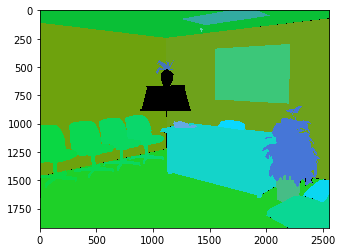

In [332]:
img = plt.imread(img_path)
plt.imshow(img)

In [337]:
bboxes = v2get_bbox(img_path)

(1920, 2560)


In [ ]:
draw_bbox(img_path=img_path,bboxes=bboxes)
idx = 0
plt.savefig(os.path.join(new_folder_path,f"test{idx:08}.png"))

In [343]:
ade_path = "./code/code/ADE20K_2016_07_26/images/"
train_path = os.path.join(ade_path,"training")
val_path =  os.path.join(ade_path,"validation")

new_folder_path = '/home/cindy/Documents/projets/MLPerf/datasets/code/code/new_img'

intersecting_img = set()
coco_label= False
for set_path in [val_path]:
    for letter in os.listdir(set_path):
        letter_path = os.path.join(set_path, letter)
        ADE_letter_classes = os.listdir(letter_path)
        for cur_class in ADE_letter_classes:
            class_path = os.path.join(letter_path, cur_class)
            for i,f in enumerate(os.listdir(class_path)):
                if f.endswith(".txt"):
                    txt_path = os.path.join(class_path, f)
                    with open(txt_path, 'r') as file_txt:
                        content = file_txt.read().split("\n")
                    for line in content[:-1]:
                        line = line.split(" # ")
                        if line[1] == '0':
                            ade_idx = ADE20K_CLASSES[line[3]]
                            coco_label = is_in_coco(ade_idx)
                            if coco_label:
                               # print(COCO_CLASSES_reverse[coco_label], txt_path.split("/")[-1])
                                intersecting_img.add(txt_path)
                    
                    if coco_label:  
                        img_path = os.path.join(class_path, f[:-8] + "_seg.png")
                        bboxes = v2get_bbox(img_path)
                        draw_bbox(img_path=img_path,bboxes=bboxes)
                        plt.savefig(os.path.join(new_folder_path,f"test{i:08}.png"))
                        plt.close()
                        img_jpg_path = os.path.join(class_path, f[:-8] + '.jpg')
                        draw_bbox(img_path=img_jpg_path, bboxes=bboxes )
                        plt.savefig(os.path.join(new_folder_path,f"test{i:08}.jpg"))
                        plt.close()
                    coco_label = False

KeyboardInterrupt: 

In [ ]:
def is_in_coco(ade20K_class_idx):
    if ade20K_class_idx == 0:
        return None
    
    label = ADE20K_CLASSES_reverse[ade20K_class_idx].split(", ")
    for single_label in label:
        if single_label in COCO_CLASSES.keys():
            return COCO_CLASSES[single_label]
    return None